In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from urllib import request
import datasets
import pandas as pd
import torch
from torch.utils.data import DataLoader
import transformers
from transformers.models.auto.modeling_auto import AutoModelForSeq2SeqLM
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import pickle
import evaluate
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import math

In [ ]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda") if cuda_available else torch.device("cpu")
print(device)

cuda


In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

data_tr = dpm.train_task1_df
data_tr.head()
data_te = dpm.train_task1_df.copy(deep=True)



# Rebuild training set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data_tr.loc[data_tr.par_id == parid].keyword.values[0]
  text = data_tr.loc[data_tr.par_id == parid].text.values[0]
  label = data_tr.loc[data_tr.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })

trdf1 = pd.DataFrame(rows)
# Split into train and internal dev set
train_data, internal_dev_data = train_test_split(trdf1, test_size=0.2, random_state=69)

In [ ]:
# Upsample positive pcl class
pcldf = train_data[train_data.label==1]
upsample_factor = 8 # 9 = 1:1 ratio approximately

#npos = len(pcldf)
#augmented_data = pd.read_pickle("augmented_data.pkl")
#augmented_data_df = pd.DataFrame(augmented_data, columns=['text'])
#augmented_data_df['label'] = 1
#augmented_data_df['text'] = augmented_data_df['text'].str.replace('\n\n', '')

upsampled = pd.concat([pcldf]*upsample_factor)

#training_set_even = pd.concat([pcldf,train_data[train_data.label==0][:npos*10]])
training_set_even = pd.concat([pcldf, upsampled, train_data[train_data.label==0]])
#training_set_even = pd.concat([training_set_even, augmented_data_df.sample(n=500, random_state=42)], ignore_index=True)

In [ ]:
training_set_even["label"].value_counts()

1    6233
0    6063
Name: label, dtype: int64

In [ ]:
training_set_even.head()

,par_id,community,text,label
0,1052,homeless,"There is infinitely more to be done , of cours...",1
1,496,refugee,Hundreds of thousands of Rohingya refugees liv...,1
2,2509,homeless,"""2015 donation drives , feed the hungry , and ...",1
3,3598,in-need,For her unwavering commitment to aiding those ...,1
4,9923,hopeless,The first point worth mentioning is low levels...,1


# Rebuild official dev set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data_te.loc[data_te.par_id == parid].keyword.values[0]
  text = data_te.loc[data_te.par_id == parid].text.values[0]
  label = data_te.loc[data_te.par_id == parid].label.values[0]
  orig_label = data_te.loc[data_te.par_id == parid].orig_label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label,
      'orig_label':orig_label
  })
tedf1 = pd.DataFrame(rows)

# Rebuild official test set

In [ ]:
rows=[]
with open("task4_test.tsv") as f:
  for line in f:
    t=line.strip().split('\t')
    rows.append(t)
official_test_set = pd.DataFrame(rows, columns="par_id art_id community country text".split())

# Hyperparameters

In [ ]:
batch_size = 8
learning_rate = 1e-5
pretrained_model = "microsoft/deberta-base"
num_epochs = 1

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(pretrained_model, num_labels=2)
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

# Backtranslation experiment (not used in final model)

In [ ]:
# en_de_tokenizer = transformers.AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
# en_fr_tokenizer = transformers.AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
# en_es_tokenizer = transformers.AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")

# de_en_tokenizer = transformers.AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")
# fr_en_tokenizer = transformers.AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fr-en")
# es_en_tokenizer = transformers.AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-es-en")

# en_to_de = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de").to(device)
# de_to_en = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-de-en").to(device)
# en_to_es = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-es").to(device)
# es_to_en = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-es-en").to(device)
# en_to_fr = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-fr").to(device)
# fr_to_en = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-fr-en").to(device)

# pcl_train_ones = train_data[train_data["label"] == 1]
# pcl_text = pcl_train_ones["text"].values.tolist()
# from_de = []
# from_fr = []
# from_es = []

# text_dataloader = DataLoader(pcl_text, batch_size=batch_size, shuffle=False)

# for batch in text_dataloader:
#   #print(batch)
#   translated_de = en_to_de.generate(**en_de_tokenizer(batch, return_tensors="pt", padding=True, truncation='longest_first').to(device))
#   de_text = [en_de_tokenizer.decode(t, skip_special_tokens=True) for t in translated_de]
#   backtranslated_de = de_to_en.generate(**de_en_tokenizer(de_text, return_tensors="pt", padding=True).to(device))
#   backtranslated_de_text = [de_en_tokenizer.decode(t, skip_special_tokens=True) for t in backtranslated_de]
#   from_de += backtranslated_de_text

#   translated_fr = en_to_fr.generate(**en_fr_tokenizer(batch, return_tensors="pt", padding=True, truncation='longest_first').to(device))
#   fr_text = [en_fr_tokenizer.decode(t, skip_special_tokens=True) for t in translated_fr]
#   backtranslated_fr = fr_to_en.generate(**fr_en_tokenizer(fr_text, return_tensors="pt", padding=True).to(device))
#   backtranslated_fr_text = [en_fr_tokenizer.decode(t, skip_special_tokens=True) for t in backtranslated_fr]
#   from_fr += backtranslated_fr_text

#   translated_es = en_to_es.generate(**en_es_tokenizer(batch, return_tensors="pt", padding=True, truncation='longest_first').to(device))
#   es_text = [en_es_tokenizer.decode(t, skip_special_tokens=True) for t in translated_es]
#   backtranslated_es = es_to_en.generate(**es_en_tokenizer(es_text, return_tensors="pt", padding=True).to(device))
#   backtranslated_es_text = [es_en_tokenizer.decode(t, skip_special_tokens=True) for t in backtranslated_es]
#   from_es += backtranslated_es_text

# pcl_train_from_de = pcl_train_ones
# pcl_train_from_fr = pcl_train_ones
# pcl_train_from_es = pcl_train_ones

# pcl_train_from_de["text"] = from_de
# pcl_train_from_fr["text"] = from_fr
# pcl_train_from_es["text"] = from_es

# pcl_train = pd.concat([pcl_train_from_de, pcl_train_from_fr, pcl_train_from_es], axis=0)
# pcl_aug = pd.concat([pcl_train_from_de, pcl_train_from_fr, pcl_train_from_es], axis=0)
# aug_train = pd.concat([train_data, pcl_train_from_de, pcl_train_from_fr, pcl_train_from_es], axis=0)
# aug_train_ds = datasets.Dataset.from_pandas(aug_train)
# tokenized_aug_train = tokenized_aug_train.remove_columns(["text", "community", "par_id", "__index_level_0__"])
# tokenized_aug_train = tokenized_aug_train.rename_column("label", "labels")
# tokenized_aug_train.set_format("torch")
# train_dataloader = DataLoader(tokenized_aug_train, shuffle=True, batch_size=batch_size)

In [ ]:
training_set_even = training_set_even[['text', 'label']]
training_set_even = datasets.Dataset.from_pandas(training_set_even)
training_set_even = training_set_even.map(tokenize_function, batched=True)
#training_set_even = training_set_even.remove_columns(["text", "__index_level_0__"])
training_set_even = training_set_even.remove_columns(["text"])
training_set_even = training_set_even.rename_column("label", "labels")
training_set_even.set_format("torch")
train_even_dataloader = DataLoader(training_set_even, shuffle=True, batch_size=batch_size)

internal_dev_data = internal_dev_data[['text', 'label']]
internal_dev_data = datasets.Dataset.from_pandas(internal_dev_data)
internal_dev_data = internal_dev_data.map(tokenize_function, batched=True)
#internal_dev_data = internal_dev_data.remove_columns(["text", "__index_level_0__"])
internal_dev_data = internal_dev_data.remove_columns(["text"])
internal_dev_data = internal_dev_data.rename_column("label", "labels")
internal_dev_data.set_format("torch")
internal_dev_dataloader = DataLoader(internal_dev_data, shuffle=True, batch_size=batch_size)

official_dev_set = tedf1[['text', 'label']]
official_dev_set = datasets.Dataset.from_pandas(official_dev_set)
official_dev_set = official_dev_set.map(tokenize_function, batched=True)
official_dev_set = official_dev_set.remove_columns(["text"])
official_dev_set = official_dev_set.rename_column("label", "labels")
official_dev_set.set_format("torch")
# need to submit predictions for the official dev set so shuffle is set to False to preserve order
official_dev_set_dataloader = DataLoader(official_dev_set, shuffle=False, batch_size=batch_size)

official_test_set = official_test_set[["text"]]
official_test_set = datasets.Dataset.from_pandas(official_test_set)
official_test_set = official_test_set.map(tokenize_function, batched=True)
official_test_set = official_test_set.remove_columns(["text"])
official_test_set.set_format("torch")
# need to submit predictions for the official test set so shuffle is set to False to preserve order
official_test_set_dataloader = DataLoader(official_test_set, shuffle=False, batch_size=batch_size)

Map:   0%|          | 0/12296 [00:00<?, ? examples/s]

Map:   0%|          | 0/1675 [00:00<?, ? examples/s]

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

In [ ]:
official_test_set

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3832
})

# Loading in the transformer

In [ ]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(pretrained_model)
model.to(device)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classi

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermed

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
from tqdm.auto import tqdm
num_training_steps = num_epochs * len(train_even_dataloader)
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_even_dataloader:
        #print(batch.items())
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    validation_metric = evaluate.combine(["accuracy", "precision", "f1", "recall"])
    model.eval()
    
    for batch in internal_dev_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        max_pred = max(0, torch.max(predictions))
        min_pred = min(1, torch.min(predictions))
        validation_metric.add_batch(predictions=predictions, references=batch["labels"])

    print(validation_metric.compute())

In [ ]:
metric = evaluate.combine(["accuracy", "precision", "f1", "recall"])
model.eval()
for batch in official_dev_set_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    max_pred = max(0, torch.max(predictions))
    min_pred = min(1, torch.min(predictions))
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

In [ ]:
#torch.save(model.state_dict(), "model")

In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(str(pi)+'\n')

In [ ]:
# loading + reronning
metric = evaluate.combine(["accuracy", "precision", "f1", "recall"])
model = transformers.AutoModelForSequenceClassification.from_pretrained(pretrained_model)
model.to(device)

dev_predictions_out = []

model.load_state_dict(torch.load("model"))
model.eval()
for batch in official_dev_set_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    dev_predictions_out = dev_predictions_out + predictions.flatten().tolist()
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classi

{'accuracy': 0.9288443170964661,
 'precision': 0.65625,
 'f1': 0.5849582172701949,
 'recall': 0.5276381909547738}

In [ ]:
labels2file(dev_predictions_out, "dev.txt")

In [ ]:
test_predictions_out = []
model.eval()
for batch in official_test_set_dataloader:
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)
  
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)
  test_predictions_out = test_predictions_out + predictions.flatten().tolist()

In [ ]:
labels2file(test_predictions_out, "test.txt")

# Dev metrics

In [ ]:
with open("dev.txt") as f:
  dev_predictions = f.readlines()
dev_predictions = [int(line.strip()) for line in dev_predictions]
dev_with_pred = tedf1.copy(deep=True)
dev_with_pred['predicted_label'] = dev_predictions
dev_with_pred['predicted_label'].tolist() == dev_predictions

True

In [ ]:
dev_with_pred

,par_id,community,text,label,orig_label,predicted_label
0,4046,hopeless,We also know that they can benefit by receivin...,1,3,0
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1,4,1
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1,2,0
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4,1
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1,3,0
...,...,...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0,0,0
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0,0,0
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0,0,0
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0,1,0


In [ ]:
with open('dev_with_pred.pickle', 'wb') as f:
    pickle.dump(dev_with_pred, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print("f1:", f1_score(dev_with_pred['label'].tolist(), dev_with_pred['predicted_label'].tolist(), average=None))
print("accuracy:", accuracy_score(dev_with_pred['label'].tolist(), dev_with_pred['predicted_label'].tolist()))
print("precision:", precision_score(dev_with_pred['label'].tolist(), dev_with_pred['predicted_label'].tolist(), average=None))
print("recall:", recall_score(dev_with_pred['label'].tolist(), dev_with_pred['predicted_label'].tolist(), average=None))

f1: [0.96108645 0.58495822]
accuracy: 0.9288443170964661
precision: [0.95139607 0.65625   ]
recall: [0.97097625 0.52763819]


<BarContainer object of 10 artists>

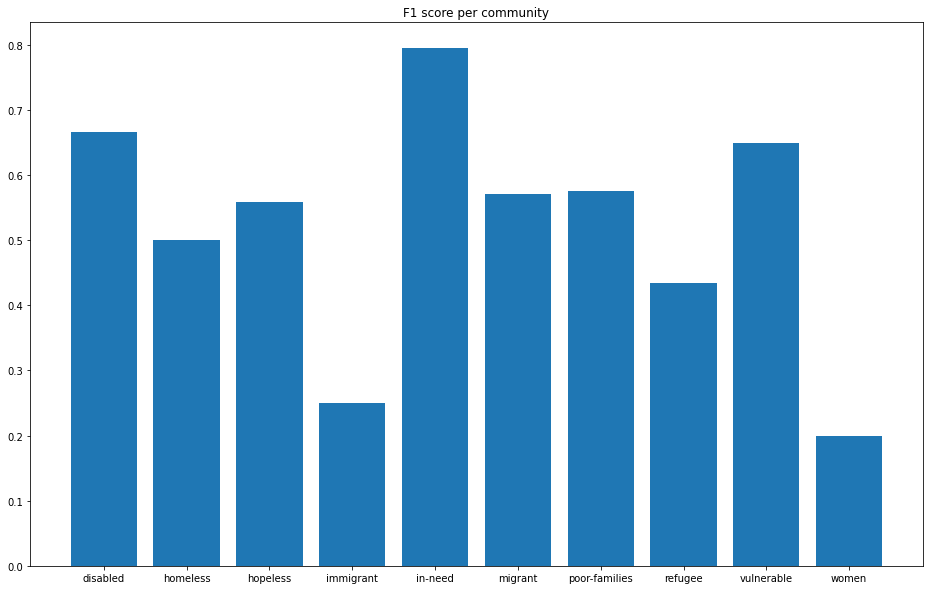

In [ ]:
# load dev_with_pred.pickle file into dataframe
import pandas as pd
dev_with_pred_df = pd.read_pickle("dev_with_pred.pickle")

#dev_with_pred_df.head()
# work out the f1 score per "community"
dev_with_pred_df.groupby("community").apply(lambda x: f1_score(x["label"], x["predicted_label"]))

# plot the f1 score per "community"
# barchart that is vertical not horizontal
plt.figure(figsize=(16,10))
plt.title("F1 score per community")
# vertical barchart
plt.bar(dev_with_pred_df.groupby("community").apply(lambda x: f1_score(x["label"], x["predicted_label"])).index, dev_with_pred_df.groupby("community").apply(lambda x: f1_score(x["label"], x["predicted_label"])).values)


In [ ]:
def tokenize_no_padding(examples):
  return tokenizer(examples["text"], padding=False, truncation=True)
dev_with_pred_ds = datasets.Dataset.from_pandas(dev_with_pred_df)
dev_with_pred_ds = dev_with_pred_ds.map(tokenize_no_padding, batched=True)
dev_with_pred = pd.DataFrame(dev_with_pred_ds)
dev_with_pred["no_of_tokens"] = dev_with_pred["input_ids"].apply(len)
dev_with_pred["no_of_words"] = dev_with_pred["text"].apply(lambda x: len(x.split()))
#print(dev_with_pred["no_of_tokens"].max(), dev_with_pred["no_of_words"].max())
#max_tokens = dev_with_pred["no_of_tokens"].max()
#max_words = dev_with_pred["no_of_words"].max()

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [ ]:
dev_with_pred.head()

dev_with_pred.to_pickle("dev_with_pred_new.pickle")

#dev_with_pred.groupby("no_of_tokens").apply(lambda x: f1_score(x["label"], x["predicted_label"]))

# plot the f1 score per "community"
# barchart that is vertical not horizontal
#plt.figure(figsize=(16,10))
#plt.title("F1 score per number of tokens")
# vertical barchart
#plt.bar(dev_with_pred.groupby("no_of_tokens").apply(lambda x: f1_score(x["label"], x["predicted_label"])).index, dev_with_pred_df.groupby("community").apply(lambda x: f1_score(x["label"], x["predicted_label"])).values)


In [ ]:
# load dev_with_pred_new.pickle file into dataframe
import numpy as np

dev_with_pred_new_df = pd.read_pickle("dev_with_pred_new.pickle")

# divide no_of_tokens into bins, 0-10, 10-20, 30-40, ...
dev_with_pred_new_df["no_of_tokens_bins"] = pd.cut(dev_with_pred_new_df["no_of_tokens"], bins=range(0, 360, 10), right=False)

dev_with_pred_new_df.head()
# plot the f1 score per "no_of_tokens"

# print the maximum no_of_tokens value
print(dev_with_pred_new_df["no_of_tokens"].max())

# new column which is unique id for each no_of_tokens_bins, 0-10=0, 10-20=1, 20-30=2, ...
dev_with_pred_new_df["no_of_tokens_bins_id"] = dev_with_pred_new_df["no_of_tokens_bins"].cat.codes

# display all entries where dev_with_pred_new_df["no_of_tokens_bins_id"] == 0
# remove entry where dev_with_pred_new_df["no_of_tokens_bins_id"] == -1
dev_with_pred_new_df = dev_with_pred_new_df[dev_with_pred_new_df["no_of_tokens_bins_id"] != -1]


dev_with_pred_new_df.head()
xlabels = ["[0,10)", "[10,20)", "[20,30)", "[30,40)", "[40,50)", "[50,60)", "[60,70)", "[70,80)", "[80,90)", "[90,100)", "[100,110)", "[110,120)", "[120,130)", "[130,140)", "[140,150)", "[150,160)", "[160,170)", "[170,180)", "[180,190)", "[190,200)", "[200,210)", "[210,220)", "[220,230)", "[230,240)", "[240,250)", "[250,260)", "[260,270)", "[270,280)", "[280,290)", "[290,300)", "[300,310)", "[310,320)", "[320,330)", "[330,340)", "[340,350)"]
xunique = np.arange(1, 36, 1).tolist()

#dev_with_pred_new_df.head()

# plot the f1 score per "no_of_tokens_bins_id"

plt.figure(figsize=(15,6))
plt.title("F1 score per sequence length")
plt.xticks(xunique, xlabels, rotation=90)
plt.bar(dev_with_pred_new_df.groupby("no_of_tokens_bins_id").apply(lambda x: f1_score(x["label"], x["predicted_label"])).index, dev_with_pred_new_df.groupby("no_of_tokens_bins_id").apply(lambda x: f1_score(x["label"], x["predicted_label"])).values)




([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

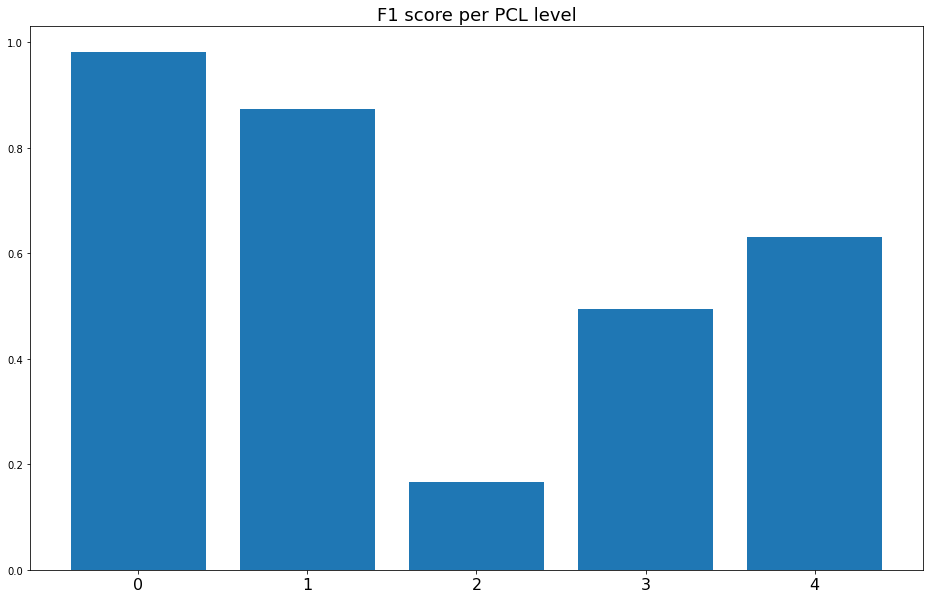

In [ ]:
#dev_with_pred_df.head()
# work out the f1 score per "community"
dev_with_pred_df.groupby("orig_label").apply(lambda x: f1_score(x["label"], x["predicted_label"]))

# plot the f1 score per "pcl label"
# barchart that is vertical not horizontal
plt.figure(figsize=(16,10))
plt.title("F1 score per PCL level", fontsize=18)
# vertical barchart
plt.bar(dev_with_pred_df.groupby("orig_label").apply(lambda x: f1_score(x["label"], x["predicted_label"], average='micro')).index, dev_with_pred_df.groupby("orig_label").apply(lambda x: f1_score(x["label"], x["predicted_label"], average='micro')).values)
plt.xticks(fontsize=16)
